# Processing of particle tracks 
### <font color='gray'>coded to work with experiments and simulation</font>

## _Import of python libraries used within the code_

### <font color ='gray'> load both code cells  </font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess # these 2 lines below load OS functionality
import sys
import json

from IPython.display import display, HTML

import sympy as sp
import mpmath as mp

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['font.size'] = 18
from matplotlib.collections import PolyCollection
import matplotlib.colors as mcolors

import scipy.constants as ct
import ipywidgets

from scipy.spatial import Voronoi, voronoi_plot_2d

import scipy.optimize as optimize
from sympy import var
from collections import Counter
import time

# system size for a given (npart, rho) configuration
def L(npart, rho):
    l = np.sqrt(npart*2*np.sqrt(3.)/rho)
    return l

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
#from __future__ import print_function

In [45]:
%matplotlib inline 

# %matplotlib tk # this one displays plots into separate windows. it's best for saving to PDF/EPS

## _Read tracking data _ 

We explain the action of each of these functions below:

__(simple_pickle_read) :__
This 'simple_pickle_read' takes a pkl file of xy positions and tracks (no velocities) and stores in 'tabla' pandas data frame 

In [2]:
# This function reads pickle binary file (.pkl) with trajectories
def get_info(hash_prefix):
    global info
    nombre = 'datos/' + str(hash_prefix) + '_experiment_info.txt'
    with open(nombre) as f:
        jsonstr = json.load(f)
    info = pd.io.json.json_normalize(jsonstr)
    return info

def simple_pickle_read(nombre):
    global datos_0, Nframes, Ntracks
    # Read table in pickle format
    nombre = 'datos/' + str(hash_prefix) + '_traj_roi.pkl.xz'
    tabla = pd.read_pickle(nombre, compression='infer')
    tabla = tabla.reset_index(drop=True) # por si los indices salen desordenados
    datos_0 = tabla
    Nframes = np.max(tabla.frame)
    Ntracks = np.max(tabla.track)
    print('Number of frames in the movie: ', Nframes)
    print('Number of tracks detected along: ', Ntracks)
    return tabla

In [3]:
hash_prefix = 7406525166311639896
info = get_info(hash_prefix)
display(HTML(info.T.to_html()))
datos = simple_pickle_read(hash_prefix)
datos.head()

,0
N,170
associated_code,D:/videos 03-05-2019/7406525166311639896_code.zip
camera_distance,0.535
date,2019-05-03 12:48:31
experiment_id,7406525166311639896
exposure,0.00150002
fps,250
lights,luzLejana
n_frames,24981
original_file,D:/videos 03-05-2019/pelotas_luzLejana_CamaraC...


Number of frames in the movie:  24981
Number of tracks detected along:  1429


,frame,track,x,y
0,1,0,636.114646,784.654599
1,1,1,294.797327,408.830346
2,1,2,654.406333,396.692333
3,1,3,415.921405,390.476144
4,1,4,871.161312,376.626673


In [7]:
info.N[0]

170

In [8]:
info.fps[0]

250

In [9]:
info.particle_diameter_px[0]

78

## _Get partial tables from global table - functions _ 

__track(t_id) :__

Outputs the complete history for the 't_id' track

In [4]:
#####  INDIVIDUAL TRACKS ##############
def track(t_id, tabla, dropit):
    t1 = tabla.loc[tabla['track'] == t_id].reset_index(drop=dropit)
    return t1

#####  INSTANTANEOUS STATES  ##############
# BUILD INSTANTANEOUS STATES OF THE SYSTEM
def get_state(it, tabla):
    st = tabla[ (tabla.frame == it) ]
    # reset row index (otherwise keeps chunks of the original table)
    st = st.reset_index(drop=True)
    return st

def get_xy_state(it, tabla):
    st = get_state(it, tabla)
    cols = ['x','y']
    xy = st[cols]
    return xy

# build instantaneous states over all frames
def get_all_states(Nframes, tabla):
    global simple_state
    simple_state = [[] for i in range(Nframes)]
    for i in range(Nframes):
        simple_state[i] = get_simple_state(i,tabla)


In [5]:
track(123,datos, True).head()

,frame,track,x,y
0,1292,123,262.241319,361.571812
1,1293,123,262.745489,360.852327
2,1294,123,263.125884,360.465975
3,1295,123,263.692392,359.997176
4,1296,123,264.380326,359.668233


## _Reduce global table - functions _ 

__one_red:__ 
Eliminates 'lonely' tracks (particles tracked for just 1 frame), re-indexes so that no track indexes are empty

__n_red:__ 
Eliminates tracks detected for n frames or less, re-indexes so that no track indexes are empty

__roi_red:__
Eliminates tracks that fall outside ROI- 1.5 sigma (sigma being ball diameter)

In [7]:
def short_drop(ishort, tabla):
    global shorts_list, Ntracks
    shorts_list =[]
    Ntracks = np.max(tabla.track)
    for i in range(Ntracks):
        t1 = track(i,tabla,False)
        if  0 < len(t1) < ishort+1:
            shorts_list.append(i)
            len0 = len(tabla)
            tabla = tabla.drop(t1['index'])
            printp(str(len(tabla)-len0))
    print('\n')
    Ntracks = np.max(tabla.track)
    return tabla

def reset_track_indexes(tabla):
    global Ntracks
    """ This function takes a dataframe in which some trajectory indexes
        are missing (maybe due to having deleted short trajectories) and
        resets indexes so that we can loop over the tracks with 'range' """
    # 'real_number_of_tracks' should be <=  than 'current_last_particle_index'
    Ntracks = len(set(tabla.track))

    original_indexes = np.array(list(set(tabla.track)))
    fixed_indexes = np.arange(0, Ntracks, step=1)
    if Ntracks < np.max(tabla.track): # fix only if there are empty tracks
        # With these two lists we create a dictionary and map old values to new ones
        n_empty = np.max(tabla.track) - Ntracks
        replacement_dict = dict(zip(original_indexes, fixed_indexes))
        tabla.track = tabla.track.map(replacement_dict)
        print('no. of short tracks fixed: ', n_empty, '\n')
    else:
        print('nothing to fix\n')
    return tabla

In [8]:
reset_track_indexes(datos);

no. of short tracks fixed:  246 



In [9]:
# drop tracks that last just 1 frame, store the dropped tracks list in one_list
datos_20 = short_drop(20,datos)
# re-index table, so that no empty tracks are left
datos_20 = reset_track_indexes(datos_20)
#datos_20.head()

-15

no. of short tracks fixed:  61 



## _Get velocities from tracks _ 

__vels(tabla) :__

Ouputs velocities from tracks table

In [10]:
def vels_diff(tabla):
    tabla['vx'] = np.zeros(len(tabla))
    tabla['vy'] = np.zeros(len(tabla))
    for k in range(Ntracks):
        if len(tabla[tabla.track==k])>1:
            t1 = track(k, tabla, False)
            printp('diffs: ' + str(k+1)+ ' of ' + str(Ntracks) + ' tracks')
            tabla.loc[t1['index'][:-1],'vx'] = np.diff(t1.x) 
            tabla.loc[t1['index'][:-1],'vy'] = np.diff(t1.y) 
    print('\n')
    return tabla

def vels_gradient(tabla):
    tabla['vx'] = np.empty(len(tabla))
    tabla['vy'] = np.empty(len(tabla))
    for k in range(Ntracks):
        if len(tabla[tabla.track==k])>1:
            t1 = track(k, tabla,False)
            printp('grads: '+ str(k+1)+ ' of ' + str(Ntracks) + ' tracks')
            tabla.loc[t1['index'],'vx'] = np.gradient(t1.x)
            tabla.loc[t1['index'],'vy'] = np.gradient(t1.y)
    print('\n')
    return tabla


In [11]:
vels_diff(datos_20);
#tabla_grad = vels_gradient(tabla)

diffs: 1121 of 1121 tracks



In [12]:
datos_20.head()

,frame,track,x,y,vx,vy
0,1,0,636.114646,784.654599,0.190609,-0.143620
1,1,1,294.797327,408.830346,0.238376,-0.653569
2,1,2,654.406333,396.692333,-0.076509,0.196054
3,1,3,415.921405,390.476144,-0.313581,-0.358458
4,1,4,871.161312,376.626673,-0.575393,-0.424805


In [39]:
def self_vel_corr(tabla):
    global svc
    end = len(tabla)-1
    svc = np.zeros(end-1) # self-velocity correlations
    for i in range(1, end-1):
        print(i,'\n')
        for k in range(end-i):
            svc[k] = svc[k] + tabla.vx[k]*tabla.vx[k+i]/(end-i)

In [16]:
ttt = track(123, datos_20, True)

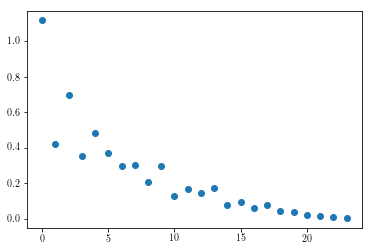

In [46]:
plt.figure(56)
plt.plot(svc,'o')

In [30]:
ttt.vx[24]

0.24870506535944514

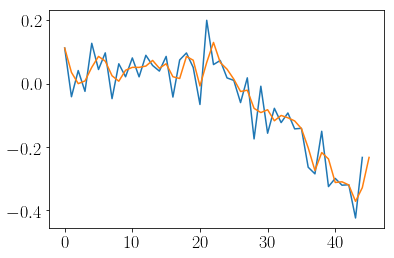

In [168]:
plt.figure(1)
plt.plot(np.diff(track(200, tabla, True).x))
plt.plot(np.gradient(track(200, tabla, True).x))

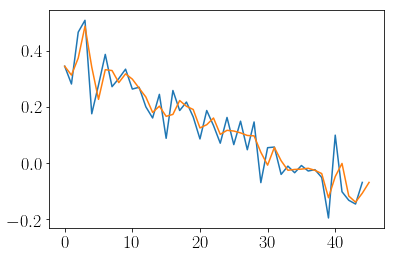

In [169]:
plt.figure(1)
plt.plot(np.diff(track(200, tabla, True).y))
plt.plot(np.gradient(track(200, tabla, True).y))

## Bring data to physical units

We take as coordinate origin the mid-point of the max and min X and Y positions ever tracked within the region of interest (ROI) during the experiment.

We have 2 options for lengh unit: 
* milimeters 
* Ball diameter

The time scale unit is seconds.

Only after this step position differences in the original data table are re-scaled as real velocities

In [459]:
# PHYSICAL SCALES AND ORIGIN
# Usage: re_pos_scale(0) for 1 mm as length unit; re_pos_scale(1) for ball diameter (sigma) 
# length unit

def scale(l_unit, t_unit, tabla):
    inv_l_unit = 1./l_unit
    tabla_scaled = tabla.copy()
    #tabla_scaled = pd.DataFrame(np.zeros(np.shape(tabla)), columns = c_xy)
    if np.any(tabla.columns=='vx') or np.any(tabla.columns=='vy'):
        tabla_scaled[['x','y', 'vx', 'vy']] = tabla[['x','y','vx','vy']] * inv_l_unit
        tabla_scaled[['vx', 'vy']] = tabla_scaled[['vx', 'vy']] * t_unit
    else:
        tabla_scaled[['x','y']] = tabla[['x','y']] * inv_l_unit
    return tabla_scaled


In [460]:
datos_20_scaled = scale(info.pixel_ratio[0], info.fps[0], datos_20 )

In [464]:
track(20,datos_20,True).head()

,frame,track,x,y,vx,vy
0,1,20,457.276067,125.966474,0.360137,0.105615
1,2,20,457.636204,126.072089,0.427036,0.173188
2,3,20,458.063240,126.245277,0.533326,0.186292
3,4,20,458.596567,126.431569,0.457379,0.238962
4,5,20,459.053945,126.670531,0.529548,0.000286


In [463]:
track(20,datos_20_scaled,True).head()

,frame,track,x,y,vx,vy
0,1,20,0.234501,0.064598,0.046171,0.013540
1,2,20,0.234685,0.064652,0.054748,0.022204
2,3,20,0.234904,0.064741,0.068375,0.023884
3,4,20,0.235178,0.064837,0.058638,0.030636
4,5,20,0.235412,0.064959,0.067891,0.000037


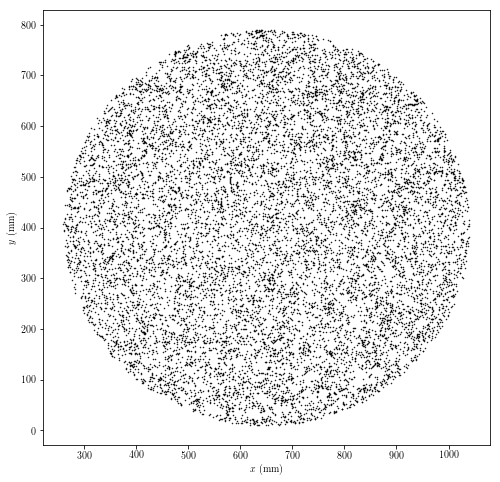

In [398]:
fig = plt.figure(figsize=(8,8))
px_size = 72./fig.dpi
plt.xlabel(r'$x~(\mathrm{mm})$')
plt.ylabel(r'$y~(\mathrm{mm})$')
plt.scatter(datos.x[::100], datos.y[::100], marker='.', s=px_size,c='k')
#plt.savefig('xy_scatter.pdf')

## Instantaneous state functions

We take as coordinate origin the mid-point of the max and min X and Y positions ever tracked within the region of interest (ROI) during the experiment.

We have 2 options for lengh unit: 
* milimeters 
* Ball diameter

The time scale unit is seconds.

Only after this step position differences in the original data table are re-scaled as real velocities

In [89]:
#####  INSTANTANEOUS STATES  ##############

### BRIDGE TO VORONOI CODE ###
# BUILD INSTANTANEOUS STATES OF THE SYSTEM
def get_state(it, tabla):
    st = tabla[ (tabla.frame == it) ]
    # reset row index (otherwise keeps chunks of the original table)
    st = st.reset_index(drop=True)
    return st

# build instantaneous states over all frames
def get_all_states(Nframes, tabla):
    global state
    state = [[] for i in range(Nframes)]
    for i in range(Nframes):
        state[i] = get_state(i, tabla)
        printp('no. of states obtained: ' + str(i) + ' of ' + str(Nframes+1))


In [86]:
# obtain state 100 from tabla
state = get_state(100,tabla)
state.head(10)

,frame,track,x,y,vx,vy
0,100,11,0.010833,0.004122,-7.749974e-11,-6.815080e-10
1,100,3,0.006399,0.005947,1.732819e-10,-4.265189e-10
2,100,6,0.008215,0.005857,3.850643e-10,8.136027e-10
3,100,1,0.004651,0.005832,-3.290583e-10,1.511007e-11
4,100,4,0.013579,0.005285,3.500378e-10,-1.314423e-10
5,100,5,0.011979,0.005123,-4.122213e-10,-2.291521e-10
6,100,7,0.015669,0.005042,-9.040271e-10,-8.070896e-10
7,100,10,0.005782,0.004812,-2.121491e-10,2.571408e-10
8,100,9,0.009715,0.004716,-2.070949e-10,-4.778495e-10
9,100,12,0.007615,0.004608,2.139170e-10,7.443302e-10


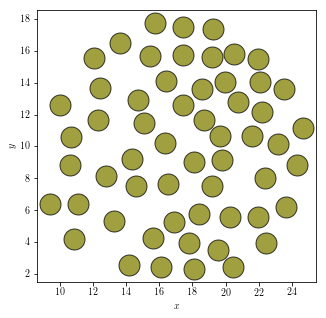

In [55]:
# DRAW INSTANTANEOUS STATE

it = 2

fig=plt.figure(0, figsize=(5,5))

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
px_size = 72./fig.dpi
plt.scatter(state[it].x, state[it].y, color='olive', s=(21.*px_size)**2
            , edgecolors='k', alpha=0.75)

# USE CIRCLE COLLECTION INSTEAD
#    col = PolyCollection([inner[i][1] for i in range(n_inner)],
#                         linewidths=0.2, facecolor= colors_built)
#    col.set_edgecolors('k')
#    graf = ax.add_collection(col)

In [90]:
# OBTAIN ALL STATES

get_all_states(Nframes, tabla)

no. of states obtained: 24980of24982

In [88]:
Nframes

24981

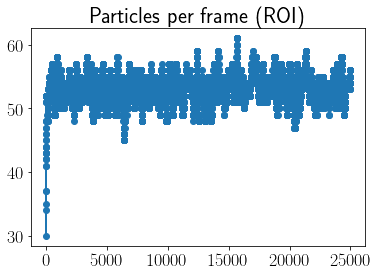

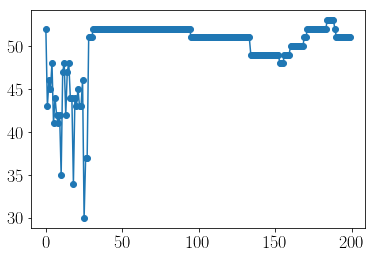

In [149]:
# plot no. of particles in each frame
plt.figure(1)
plt.title('Particles per frame (ROI)')
n_particles_frame=np.array([len(state[it]) for it in range(1,Nframes)])
plt.plot(n_particles_frame, marker='o')
plt.figure(2)
plt.plot(n_particles_frame[:200], marker='o')

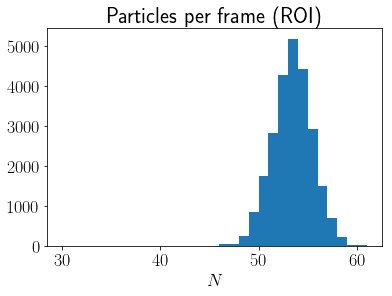

In [150]:
# Number of particles in each frame ROI. Histogram
plt.figure(1)
plt.title('Particles per frame (ROI)')
plt.xlabel(r'$N$')

n, bins, patches = plt.hist(n_particles_frame, bins=31)

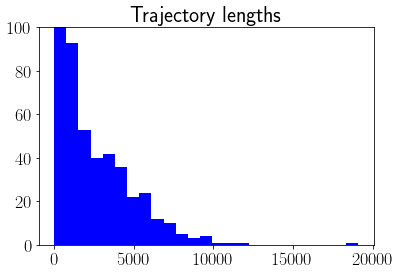

In [153]:
# Histogram of trajectory length
plt.figure(2)
plt.title('Trajectory lengths')
# set upper height limit for histogram
plt.ylim((0,100))
# number of bins
nbins = 25
#plot
plt.hist([len(track(i,tabla,True)) for i in range(Ntracks)], nbins, color='b');

In [173]:
# Total number of analyzed states (after discard of short trajectories)
np.sum([len(t[i]) for i in range(Ntrajec)])

1113887

In [ ]:
# Build array of times where particles trackings are 'lost
t_last = np.zeros(Ntrajec)
for i in range(Ntrajec):
    t_last[i] = t[i][-1]

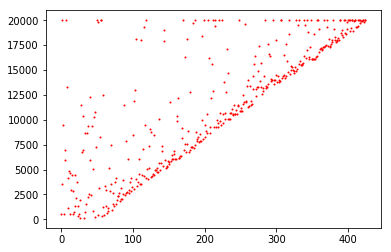

In [175]:
plt.figure(3)
plt.plot(t_last,marker='o',linewidth=0, markersize=1, color='r')

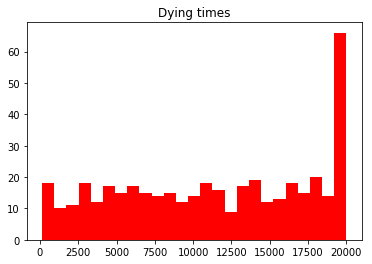

In [176]:
plt.figure(4)
plt.title('Dying times')
#number of bins
nbins = 25
#plot
plt.hist(t_last, nbins, color = 'r');

In [29]:
####### INDIVIDUAL TRAJECTORIES ##########
itraj = 45
xt = rtabla[(rtabla.trajec==45)].x
yt = rtabla[(rtabla.trajec==45)].y

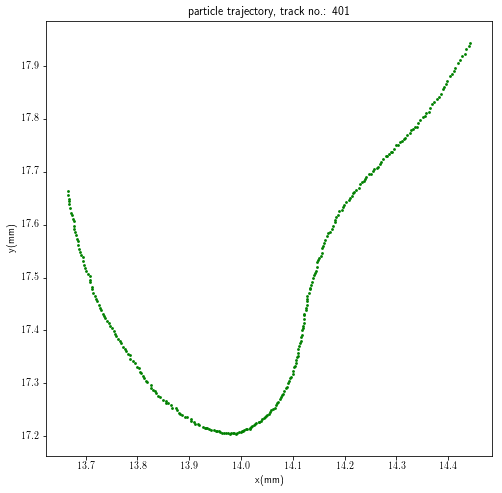

In [25]:
points= plt.figure(5,figsize=(8,8))

#size = 10
jump = 1

i_trajec = 401

plt.title('particle trajectory, track no.: '+str(i_trajec))
#plt.xlim((-size*0.5,size*0.5))
#plt.ylim((-size*0.5,size*0.5))

xt = rtabla[(rtabla.trajec==i_trajec)].x
yt = rtabla[(rtabla.trajec==i_trajec)].y

plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.scatter(xt[::jump], yt[::jump], 
            s=8, marker='o', c='g',edgecolors=None,linewidths=0)
plt.savefig('track401.pdf')

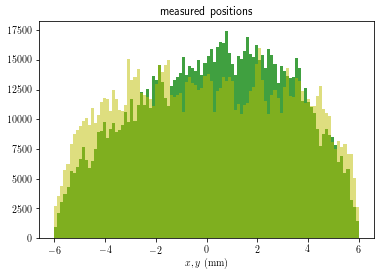

In [59]:
fig=plt.figure(6)
px_size = 72./fig.dpi
plt.title('measured positions')
plt.xlabel(r'$x, y~\mathrm{(mm)}$')
plt.hist((tabla.x -x0)/px_size, 100, color='g', alpha=0.75);
#plt.figure(3)
plt.hist((tabla.y -y0)/px_size, 100, color='y', alpha=0.5);
plt.savefig('xy_distr.pdf')

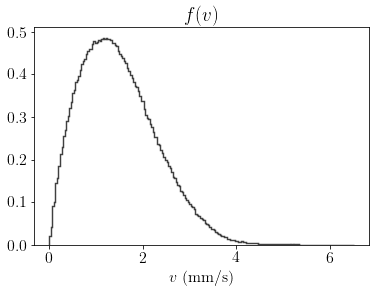

In [96]:
plt.figure(7)
plt.title(r'$f(v)$')
plt.xlabel(r'$v~\mathrm{(mm/s)}$')
plt.hist(np.sqrt((rtabla.vx**2+rtabla.vy**2)*0.5), 200,color='k',alpha=0.75
         ,normed=True, histtype='step',linewidth=1.45);
plt.savefig('fv.pdf',bbox_inches='tight')

In [102]:
import scipy.stats as st

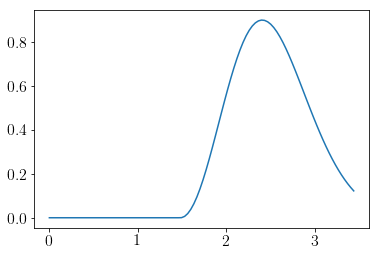

In [125]:
mu  = np.mean(np.sqrt((rtabla.vx**2+rtabla.vy**2)*0.5))
variance = np.var(np.sqrt((rtabla.vx**2+rtabla.vy**2)*0.5))
x = np.linspace(0, mu + 3*variance, 100)
plt.plot(x, st.maxwell.pdf(x,mu,variance))

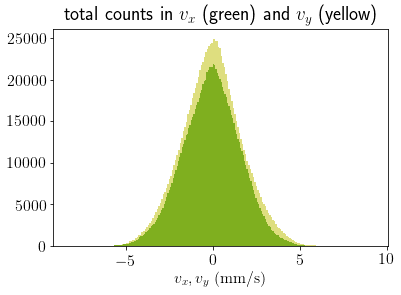

In [101]:
plt.figure(8)
plt.title(r'total counts in $v_x$ (green) and $v_y$ (yellow)')
plt.xlabel(r'$v_x, v_y~\mathrm{(mm/s)}$')

plt.hist(rtabla['vx'], 200,color='g',alpha=0.75,normed=False);
#plt.figure(5)
plt.hist(rtabla['vy'], 200,color='y',alpha=0.5,normed=False);
plt.savefig('f_vxvy_not_normed.pdf',bbox_inches='tight')

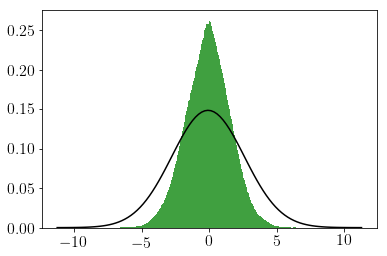

In [147]:
# v_x VARIANCE (mm/s^2)
x = np.linspace( -(mu + 15*variance), mu + 15*variance, 100)
meanx = np.mean(rtabla.vx)
variancex = np.var(rtabla.vx)
plt.plot(x,st.norm.pdf(x, meanx, variancex),color='k')
plt.hist(rtabla['vx'], 200,color='g',alpha=0.75,normed=True);

In [183]:
# v_y VARIANCE (mm/s^2)
np.mean(tabla['vy'])

-8.394719251547427e-05

## Static structure functions 

## <font color=crimson>BASE $XY$ AND VORONOI FUNCTIONS</font>

In [6]:
# all code requires definition of 'npart' 

# READ POSITIONS FROM TEXT FILE generated from MD simulations
def read_xy(path, iframe):
    #nombre = 'hex_test/'+ str(npart)+'/rho0840/accel08/xyz'+ '{0:04d}'.format(iframe) +'.dat'
    nombre = path+'xyz'+ '{0:04d}'.format(iframe) +'.dat'
    # read using numpy:
    # xy = np.loadtxt(nombre, skiprows=1, usecols=(0,1))
    # read using pandas:
    xy = pd.read_table(nombre, skiprows=1, sep = '\s+', header=None,
                        usecols = [0,1], names=['x','y'], index_col=False)
    return xy

def average_xy(path,init_frame, end_frame):
    nframes = end_frame - init_frame + 1
    xy_av = read_xy(path, init_frame)
    for i in range(init_frame+1, end_frame+1):
        xy_av = xy_av + read_xy(path, i)
    xy_av = xy_av / nframes
    return xy_av
        
        
# FILTER OUTER CELLS, returns a numpy array
def inner_xy(xy,LX, X_off, LY, Y_off):
    return list(filter(lambda x: x[0] > X_off and x[1]>Y_off and x[0]<LX-X_off and x[1]<LY-Y_off,
                       [[xy[i][0], xy[i][1]] for i in range(npart)]))

#################################################################################
# Build INNER CELLS list. BEYOND THIS POINT USAGE REQUIRES vor=Voronoi(xy)   ####
#################################################################################


# OBTAINS cell vertices for ONE simulation PARTICLE, but ONLY for INNER cells
# INNER CELL DEFINITION: any cell with none of its vertexes within the border region
# USAGE: pseudo_cell(particle number, x size, x border, y size, y border)
# RETURNS an array of 2D lists (xy vertices positions) if all vertices are inner
# for outer cells returns VOID

def pseudo_cell_xy(vor,p_id, LX, X_off, LY, Y_off):
    b = vor.points[p_id]
    if b[0] < X_off or b[0] > LX-X_off or b[1] < Y_off or b[1] > LY - Y_off:
        c = []
    else:
        c = vor.vertices[vor.regions[vor.point_region[p_id]]]
        if np.any(c.T[0] < X_off) == True or np.any(c.T[0] > LX-X_off) or np.any(c.T[1] < Y_off) == True or np.any(c.T[1] > LY-Y_off):
            c = []
    return c

# OBTAINS THE ENTIRE LIST OF INNER CELLS
# USAGE: inner(particle_simulation_index, vertices_positions_2Dcoords_array)
# RETURNS a numpy array of objects: [particle number, [pseudo_cell_xy] ] with n_inner length
# INPUTS from pseudo_cell_xy, which inputs from Voronoi

def inner_cells(vor, LX, X_off, LY, Y_off):
    global n_inner
    inner = list(filter(lambda x: len(x[1])>3 ,
                          [ [i, pseudo_cell_xy(vor,i, LX, X_off, LY, Y_off)] for i in range(npart)]))
    n_inner = len(inner)
    return inner

#############################################################################################
#############################################################################################

def set_up_graf(idf, LX, LY):
    global ax, fig_system, ss

    fig_system = plt.figure(idf, figsize=(6.5,6.5))
    ss=(72./fig_system.dpi)**2
    ax = fig_system.add_subplot(1, 1, 1)
    ax.set_ylim([0,LX])
    ax.set_xlim([0,LY])
    ax.set_xlabel(r'$x$',fontsize = 20)
    ax.set_ylabel(r'$y$', fontsize = 20)

# TODO: graph simulation snapshot from above, with circles of size = sigma (particle diameter)
def graf_xy(xy, LX, LY):
    graf = ax.scatter(xy.x, xy.y, marker='o', lw=0, s=ss,c='k')

# GRAPHS FOR VORONOI TESSELLATION, only inner cells
# USAGE: graf_vor(inner), with inner a numpy array of inner_cells objects
# RETURNS 2 graphs
# INPUTS FROM inner_cells

def graf_vor(draw_cells, draw_edges, inner, LX, LY):
    
    global fig_cells, polygon_type
    
    # Build polygon type list
    polygon_type = [len(inner[i][1]) for i in range(n_inner)]
            
    # Build color list
    colors_built = ['w' for i in range(n_inner)]
    
    for i in range(len(inner)):
        if len(inner[i][1]) == 4:
            colors_built[i] = 'dodgerblue'
        elif len(inner[i][1]) == 5:
            colors_built[i] = 'mediumseagreen'
        elif len(inner[i][1]) == 6:
            colors_built[i] = 'lemonchiffon'
        elif len(inner[i][1]) == 7:
            colors_built[i] = 'tomato'  
        elif len(inner[i][1]) == 8:
            colors_built[i] = 'pink' 

    # old code
    #fig_cells, ax = plt.subplots(1, num=3, figsize=(9.5,9.5))
        
    # Build colored Tessellation
    # Draw Voronoi polygons
    if draw_cells>0:
        if draw_edges>0:
            lw = 0.1
        else:
            lw = 0
        col = PolyCollection([inner[i][1] for i in range(n_inner)],
                         linewidths=lw, facecolor= colors_built, alpha=0.5)
        col.set_edgecolors('k')
        graf = ax.add_collection(col)

##########################################
### POLYGON TYPE HISTOGRAM ###############
##########################################

    # bar plot the histogram
    #fig_hist, ax0 = plt.subplots(1, num=1, figsize=(7,7/ct.golden))
    
            
    # build distr. f of polygons
    #sides_distr = np.histogram(polygon_type, bins =np.arange(3,15) )
    #    
    #plt.xlim(np.min(polygon_type)-1,np.max(polygon_type)+1)
    #plt.ylim(0, 1.1*np.max(sides_distr[0]))
    #
    #plt.ylabel('$N$')
    #plt.xlabel('polygon')   

    ## Compute & Display ratio of hexagons
    #hex_ratio = sides_distr[0][3]/(1.*n_inner)
    ## define text box
    #plt.text(3.25, 1.0*np.max(sides_distr[0]), 'hexagons (\%): ' + '{:.2%}'.format(hex_ratio),
    #         size=12, ha="left", va="center",
    #         bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),)
    #         )
  
    #plt.bar(sides_distr[1][:-1], height=sides_distr[0], align='center')
    
##########################################


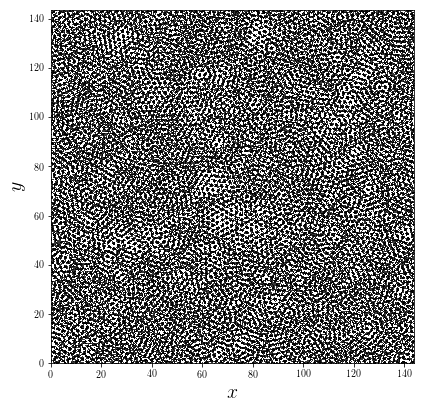

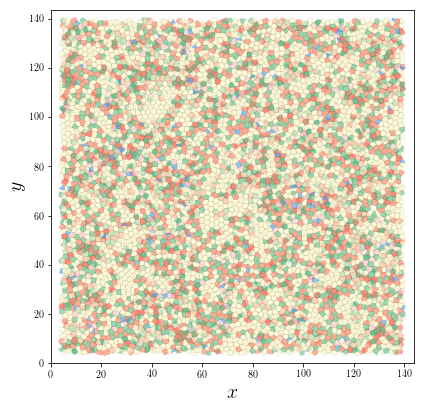

In [7]:
# CODIGO DE EJECUCION TESELACION DE VORONOI + GRAFICAS

base_path = '/home/fvega/Codigos/MD/hex_test/5000/rho0840/'
#base_path = '/home/fvega/Documentos/Apuntes/air_fluidized_exps/datos/'
#extra_path = 'hex_test/' + str(npart) + '/'
extra_path = 'accel1350/'

path = base_path + extra_path 

density = 0.840
npart = 5000
#xy = av_xy(800,990)
LX = L(npart, density) 
LY = LX

# The 3 previous lines allow for precise input of LX (if LX=LY)
X_off = 3 # this is the width of the border layer to discard
Y_off = X_off

#del fig_cells
set_up_graf(5, LX, LY)
for i in range(40):
    xy = read_xy(path, 950+i)
    grafxy = graf_xy(xy, LX, LY)

# Make Voronoi graph out of the last particle positions
vor = Voronoi(xy)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LX,Y_off=X_off)
# Represent particle positions and inner Voronoi cells
set_up_graf(6, LX, LY)
graf = graf_vor(1, 1,inner, LX, LX )

xy_av = average_xy(path,950,999)

# Make Voronoi graph out of average particle positions
vor = Voronoi(xy_av)
# Eliminate outer cells
inner = inner_cells(vor, LX=LX,X_off=X_off,LY=LX,Y_off=X_off)

# Superimpose 
graf = graf_vor(1, 1,inner, LX, LX )

In [ ]:
# RADIAL DISTRIBUTION FUNCTION

def gr(nrbin):
    global dr, hist, edges
    # The number of g(r) measurements is the binomial cofficient
    # since the points order in pairs does not matter; i.e., g(ri-rj)=g(rj-ri)
    nr_measures = int(scipy.special.binom(npart,2 ))
    print('measures per bin: ', nr_measures/nrbin) # print no. of measuremnts per bin
    # calculate the bin size, relative to particle radii
    drr = np.sqrt(LX**2 + LY**2)/nrbin
    # initialize array of radial distr function distances array and bin index
    dr = np.zeros(nr_measures)
    ii = 0
    # Loop over all statistically relevant particle pairs
    # calculating distances
    for i in range(npart-1):
        if (i%100==0 and i > 0):
            printp(str(i)+ ' particles performed')
        for j in range(i+1,npart):
            dr[ii] = (xy.x[i]-xy.x[j])**2 + (xy.y[i]- xy.y[j])**2
            ii = ii +1
    dr = np.sqrt(dr)
    # count number of measured distances per bin; i.e., get the g(r)
    hist, edges = np.histogram(dr,bins=nrbin)
    # normalize the radial distribution function
    g = [hist[i]/((npart/LX**2)*drr*drr*(i+0.5)) for i in range(len(hist))]
    # create array of bin centers
    r= [drr * (i+0.5) for i in range(len(hist))]
    return r, g

In [ ]:
%%time

nrbin = 10000
r, g = gr(nrbin)
plt.plot(r, g, 'bo', markersize=0.6125)
plt.figure()
plt.xlim(0,20)
plt.plot(r, g, 'bo', markersize=1.25)

In [ ]:
#####################################################
######### XY 2D-STRUCTURE BASE FUNCTIONS  ###########
#####################################################
# return 2D XY-bin size (dxbin, dybin)
def make_xy_bins(nxbin, nybin):
    global dxbin, dybin, rmax
    # set init BINS MATRIX
    rho = np.zeros((nxbin,nybin))
    dxbin = (LX-2*X_off)/nxbin
    dybin = (LY-2*Y_off)/nybin
    rmax = np.sqrt((nxbin*dxbin)**2 + (nybin*dybin)**2)


#####################################################
######### RADIAL STRUCTURE BASE FUNCTIONS ###########
#####################################################
# returns r-bin size (drbin)
def make_r_bins( nrbin):
    global drbin
    rho_r = np.zeros(nrbin)
    drbin = rmax/(1.0*nrbin)

    
#########################################################################
################       XY BINS FUNCTIONS            #####################
#########################################################################
# returns ixy 2D index for a particle position. used by rho
def get_particle_xy_bin(pos_xy, nxbin, nybin):
    global ii
    ii = np.zeros(2, dtype=int)
    ii[0] = int(np.floor((pos_xy[0]-X_off)/dxbin))
    ii[1] = int(np.floor((pos_xy[1]-Y_off)/dybin)) #outer particles have negative index
    if ii[0] < 0 or ii[0] >= nxbin or ii[1] < 0 or ii[1] >= nybin:
        ii[0] = -1; ii[1] = -1

# return XY particle bins: ixy[i] variable, 'i' being 
# loop only over inner particles
def rho_xy(npart, nxbin, nybin):
    global ixy, nxy
    #npart = len(xy)
    ixy = np.zeros((npart,2), dtype=int)
    nxy = np.zeros((nxbin, nybin), dtype=int)
    for i in range(npart):
        get_particle_xy_bin(xy.ix[i], nxbin, nybin)
        ixy[i] = (ii[0], ii[1]) # identify the xy bin
        if ii[0] >= 0 and ii[1] >= 0:
            nxy[ii[0]][ii[1]] = nxy[ii[0]][ii[1]] + 1 # xy bin population sum

#########################################################################
################            RADIAL BIN FUNCTIONS          ###############
#########################################################################
# XY BIN DISTANCE FUNCTION: obtains distance between square bins
# input: first xy bin, second xy bin (2 pairs of integer numbers)
def bd(ij, ijprime):
    return np.sqrt(((ij[0]-ijprime[0])*dxbin)**2 + ((ij[1]-ijprime[1])*dybin)**2)


# Obtain all r bins
# Relies on bin-distance function (bd)
# ij is the reference bin
def get_r_bin(ij, ijprime):
    global rbin
    rbin = int( np.floor(bd(ij, ijprime)/drbin))
    return int(rbin)

# counts the number of times (ahead) we find an r-bin in the xy matrix
# it aims to naturally normalize radial functions according to this number
# r-bins counts stored in:  #### nir[rbin]  ####
def r_bin_counts(nxbin, nybin, nrbin):
    global nir, rij
    # rij: variable storing the r-bin for each xy-bin pair 
    rij = np.zeros((nxbin, nybin, nxbin, nybin))
    # nir: variable storing the number of occurrences for each r-bin
    # it is used for normalization in r-functions
    nir = np.zeros(nrbin+1, dtype=int)
    snxbin = str(nxbin)
    for i in range(nxbin):
        for j in range(nybin):
            for jp in range(j+1,nybin): # if pair in the same row, just count cells ahead
                rij[i, j, i, jp] = get_r_bin((i, j), (i, jp))
                nir[rbin] = nir[rbin] + 1
            for ip in range(i+1,nxbin):
                for jp in range(nybin):
                    rij[i, j, ip, jp] = get_r_bin((i, j), (ip, jp))
                    nir[rbin] = nir[rbin] + 1
        printp('line ' + str(i+1) + ' of ' + snxbin + ' complete')
    if nir[0] == 0: 
        print('r-bin size too small, choose less r-bins')
        
# RADIAL DENSITY FUNCTION
# procedure is as follows:
# we iterate over xy-bins, which are in each case the density origin (rho(0))
# for each xy-bin, we iterate over the following bins in the matrix, 
# and update rho according to the total population of the iteration bin
# and its distance to current origin
def rho_r(nxbin, nybin, nrbin ):
    global rho, rho_p
    rho = np.zeros(nrbin)
    for i in range(nxbin):
        for j in range(nybin):
            for jp in range(j+1,nybin): # if pair in the same row, just count cells ahead
                rbin = int(rij[i, j, i, jp])
                #print(rbin)
                rho[rbin] = rho[rbin] + nxy[i,jp]
            for ip in range(i+1,nxbin):
                for jp in range(nybin):
                    rbin = int(rij[i, j, ip, jp])
                    rho[rbin] = rho[rbin] + nxy[ip,jp]

    # normalize density
    for i in range(nrbin):
        rho[i] = rho[i]/nir[i]


In [ ]:
################################
# Build NEIGHBORS LIST #########
################################
def neighbor_cells(iframe):
    Voronoi_inner(iframe)
    neighbors = [[] for i in range(npart)]
    print('no. of inner particles: ', n_inner)
    for k in range(n_inner):
        part = inner[k][0]
        # cn: coordination no. of current particle (= the number of vertices in its cell)
        cn = len(vor.regions[vor.point_region[part]])
        # list of vertices for current particle
        verts = vor.regions[vor.point_region[part]]
        # initialize list  (raw_neighbors) of lists (raw_neighbors[i])
        # sublists will end up being the list of vertices in the cell of the repeated vertex
        raw_neighbors = [[] for i in range(cn)]
    
        # for each vertex, search its repetitions in the other cells, but only in inner ones
        for j in range(cn):
            # a closest neighbor is defined as a particle that has a common a cell vertex with the ref. part.
            raw_neighbors[j]=list(filter(lambda x: any(np.array(vor.regions[vor.point_region[x]]) == verts[j])
                                     , [inner[i][0] for i in range(n_inner)] ))
        # (each raw_neighbors is now the list of particles whose cell contains current vertex)
    
        # collapse into a single list
        for j in range(1,cn):
            raw_neighbors[0]+=raw_neighbors[j]
        # filter out self-repetitions
        raw_neighbors[0]= list(filter(lambda x: x != part, raw_neighbors[0]))
        # remove duplicates from shared vertices among neighbor cells (set) and sort (sorted)  
        neighbors[part] = sorted(np.array(list(set(raw_neighbors[0]))))
        if k%100==0: printp('iteracion: ' + str(k))


In [ ]:
# ORIENTATIONAL CORRELATION FUNCTION


psi = np.zeros((nxbin, nybin)) # initialize psi matrix

for i in range(len(inner)):
    part = inner[i][0]
    icn = 1./len(neighbors[part]) 
    xyk = vor.points[part]
    rk = np.linalg.norm(xyk)
    
    xbin = int(np.floor(xyk[0]/dbin))
    ybin = int(np.floor(xyk[1]/dbin))
    
    # k is the reference particle, j is the neighbor
    for j in range(cn):
        xyj = vor.points[neighbors[part][j]]
        rj= np.linalg.norm(xyj)
        thetajk = np.arccos(np.dot(xyk,xyj)/(rj*rk))
        psi[xbin][ybin] += (np.exp(thetajk*6j)*icn)